### Edgar Moises Hernandez-Gonzalez
#### 14/05/20-02/07/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 990x31
##### Validacion cruzada

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA09E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
x = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

In [8]:
print(x.shape)
print(y.shape)

(576, 22000)
(576, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 576


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 4


In [11]:
# codificar etiquetas con valores de 0 a nClases-1
y = LabelEncoder().fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],990,31))
  temporal = np.zeros((990,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=500, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
#llamar a unir_espectrogramas_vertical_resize(data)
inicio = time.time()

x = unir_espectrogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
400
500
Tiempo: 10.89992880821228


In [14]:
print(x.shape)

(576, 990, 31)


In [15]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

498.5283956951122
2.7644712721841684e-08
2.1715118913453497


In [16]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [17]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99905485
5.5400226e-11
0.0043517244


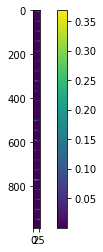

In [18]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

In [19]:
#convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(576, 1, 990, 31, 1)


In [20]:
# mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_CNN2D_LSTM_STFT09_CV.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [21]:
skf = StratifiedKFold(n_splits = 10)

In [22]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  1.4521830123046349
accuracy:  0.6896551847457886
kappa:  0.5847255369928401
confusion matrix:
 [[13  2  0  0]
 [ 5  8  1  0]
 [ 7  1  6  0]
 [ 0  0  2 13]]


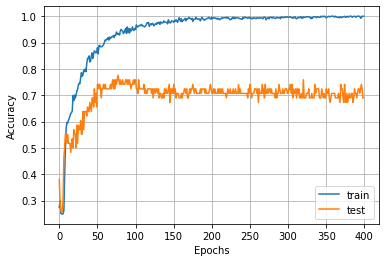

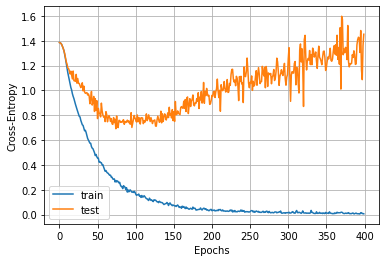


Iteration: 2
loss:  0.7846474873608557
accuracy:  0.8448275923728943
kappa:  0.7930214115781127
confusion matrix:
 [[13  1  1  0]
 [ 1 10  1  2]
 [ 0  2 12  0]
 [ 0  1  0 14]]


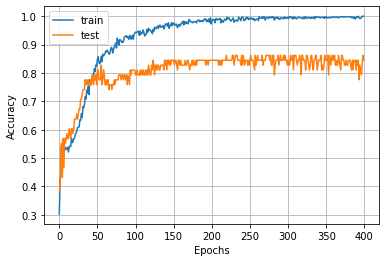

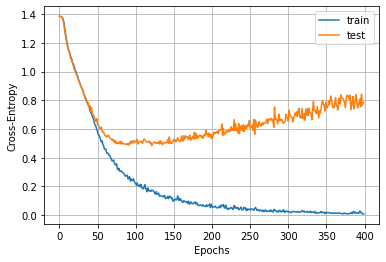


Iteration: 3
loss:  0.5274962084046726
accuracy:  0.8448275923728943
kappa:  0.7934309457855164
confusion matrix:
 [[14  0  0  0]
 [ 1 12  1  0]
 [ 0  4 11  0]
 [ 0  2  1 12]]


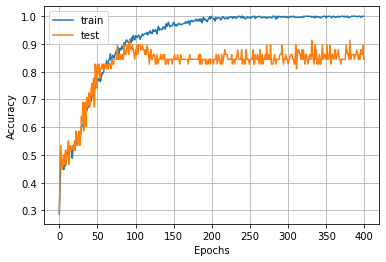

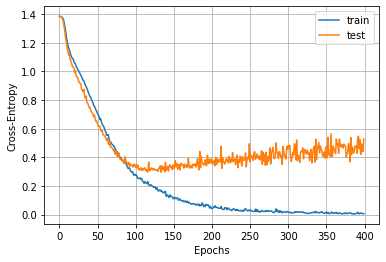


Iteration: 4
loss:  1.2663543902594467
accuracy:  0.7068965435028076
kappa:  0.6082638061183949
confusion matrix:
 [[ 9  2  2  1]
 [ 0  8  3  3]
 [ 0  3 10  2]
 [ 0  1  0 14]]


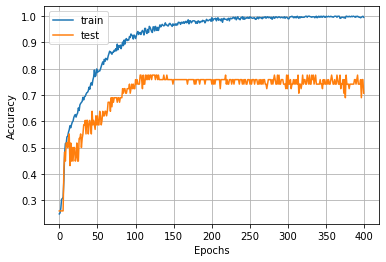

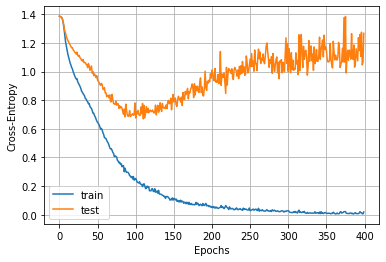


Iteration: 5
loss:  1.291477474673041
accuracy:  0.7586206793785095
kappa:  0.6777777777777778
confusion matrix:
 [[14  0  0  0]
 [ 0 11  3  1]
 [ 2  1 11  1]
 [ 0  2  4  8]]


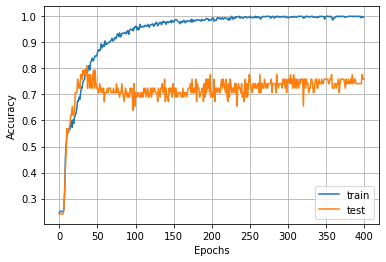

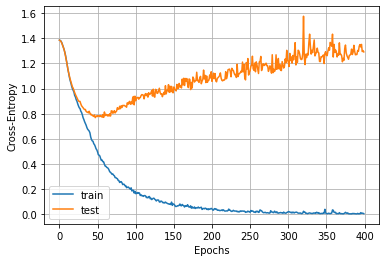


Iteration: 6
loss:  0.5523851431649307
accuracy:  0.8620689511299133
kappa:  0.8162376237623763
confusion matrix:
 [[14  0  0  0]
 [ 0 12  1  2]
 [ 0  2 11  2]
 [ 0  0  1 13]]


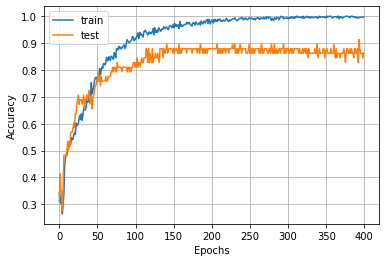

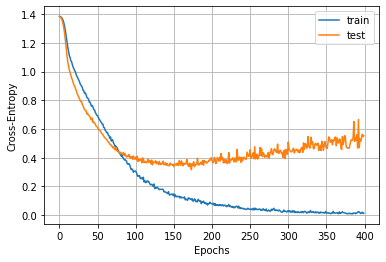


Iteration: 7
loss:  0.25869494206026983
accuracy:  0.9298245906829834
kappa:  0.9063270336894002
confusion matrix:
 [[14  0  0  0]
 [ 0 15  0  0]
 [ 0  0 14  0]
 [ 0  2  2 10]]


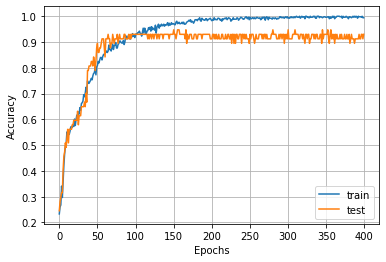

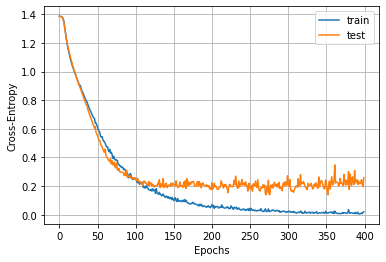


Iteration: 8
loss:  1.1318634748458862
accuracy:  0.7719298005104065
kappa:  0.695937628231432
confusion matrix:
 [[12  2  0  0]
 [ 3  9  3  0]
 [ 1  1 11  1]
 [ 0  2  0 12]]


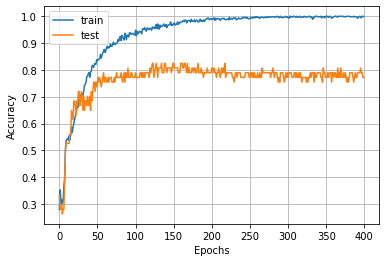

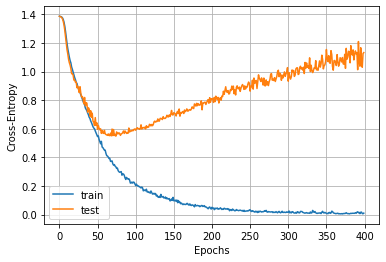


Iteration: 9
loss:  0.6519018181583338
accuracy:  0.8070175647735596
kappa:  0.7425051334702258
confusion matrix:
 [[14  1  0  0]
 [ 1  7  6  0]
 [ 1  1 12  0]
 [ 0  1  0 13]]


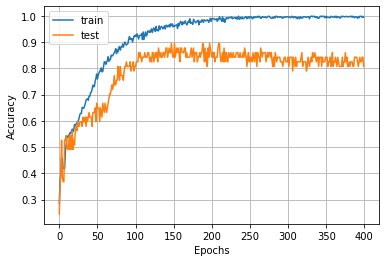

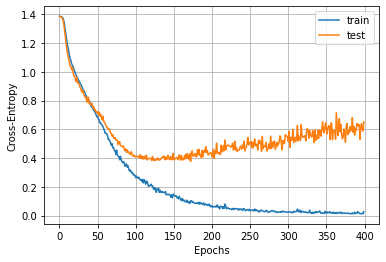


Iteration: 10
loss:  1.4034750796200937
accuracy:  0.7719298005104065
kappa:  0.6964358869315854
confusion matrix:
 [[10  3  1  1]
 [ 0 13  1  0]
 [ 0  4  8  2]
 [ 0  1  0 13]]


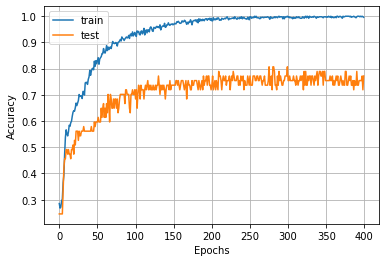

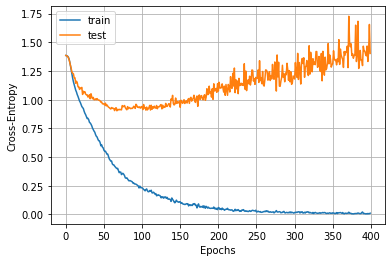


Resultados:
loss: [1.4521830123046349, 0.7846474873608557, 0.5274962084046726, 1.2663543902594467, 1.291477474673041, 0.5523851431649307, 0.25869494206026983, 1.1318634748458862, 0.6519018181583338, 1.4034750796200937]
accuracy: [0.6896551847457886, 0.8448275923728943, 0.8448275923728943, 0.7068965435028076, 0.7586206793785095, 0.8620689511299133, 0.9298245906829834, 0.7719298005104065, 0.8070175647735596, 0.7719298005104065]
kappa: [0.5847255369928401, 0.7930214115781127, 0.7934309457855164, 0.6082638061183949, 0.6777777777777778, 0.8162376237623763, 0.9063270336894002, 0.695937628231432, 0.7425051334702258, 0.6964358869315854]
Tiempo: 800.2084300518036


In [23]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test),
                      verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [24]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 1, 990, 31, 16)    160       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 495, 15, 16)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 495, 15, 16)    2320      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 1, 247, 7, 16)     0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 1, 27664)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 885536    
_________________________________________________________________
dense_19 (Dense)             (None, 128)             

In [25]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7988
std: (+/- 0.0699)
Mean Kappa: 0.7315
std: (+/- 0.0936)
Max Accuracy: 0.9298
Max Kappa: 0.9063
Tiempo: 800


In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  2 21:48:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    45W / 250W |   1093MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------